### Load Data

In [26]:
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy

from sklearn.datasets import fetch_mldata
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

In [2]:
from theano import *
import theano.tensor as T

In [3]:
mnist = fetch_mldata("MNIST original")
X = mnist.data.astype('float64')
y = mnist.target

In [4]:
num_class = 10   # {0,...,9}
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

In [5]:
train_samples = 6000

In [6]:
# 6000 1000 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=1000)

### Define Softmax
* [softmax with vectorized operations](https://mlxai.github.io/2017/01/09/implementing-softmax-classifier-with-vectorized-operations.html) <br> 
* [math part](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative)

In [7]:
def softmax_loss_vectorized(W, X, y, reg):
    """
    Softmax loss function, vectorized version.

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    N = X.shape[0]
    C = W.shape[1]

    f = X.dot(W)
    f -= np.matrix(np.max(f, axis=1)).T

    term1 = -f[np.arange(N), y]   
    sum_j = np.sum(np.exp(f), axis=1)
    term2 = np.log(sum_j)
    loss = term1 + term2
    loss /= N 
    loss += 0.5 * reg * np.sum(W * W)

    coef = np.exp(f) / np.matrix(sum_j).T
    coef[np.arange(N),y] -= 1
    dW = X.T.dot(coef)
    dW /= N
    dW += reg*W
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################

    return loss, dW

### Gradient Descent

In [8]:
y_train.astype(int)

array([1, 8, 6, ..., 9, 0, 1])

In [9]:
# initialize weights
w = np.random.random((X_train.shape[1], 10))   # (784, 10)
iterations = 500
learningRate = 1e-2
losses = []
for i in range(0,iterations):
    loss, grad = softmax_loss_vectorized(w, X_train, y_train.astype(int), 1)   # lamda = 1 for regularization
    losses.append(loss)
    w = w - (learningRate * grad)
    w = np.asarray(w)
print(losses)

[array([1309.14857272, 1308.95457363, 1309.05814034, ..., 1309.32325906,
       1309.21409611, 1309.22396712]), array([1289.9460635 , 1290.44924214, 1290.89764103, ..., 1289.94636063,
       1289.9460635 , 1289.9460635 ]), array([1264.2187513 , 1263.84768845, 1264.1089067 , ..., 1265.11089111,
       1264.03112655, 1264.47256796]), array([1268.48692648, 1268.40511428, 1268.40511428, ..., 1269.04131173,
       1268.40511428, 1268.57350708]), array([1245.96506981, 1245.92990626, 1246.16917063, ..., 1246.37592882,
       1246.88308399, 1246.16989487]), array([1225.43630477, 1226.89733906, 1225.43630477, ..., 1225.43630477,
       1225.43630477, 1225.43630477]), array([1201.26760528, 1202.20137348, 1202.48795875, ..., 1202.96401024,
       1201.26760528, 1201.40121823]), array([1170.52692663, 1171.00003143, 1170.64140711, ..., 1171.01910283,
       1170.52692663, 1170.56802214]), array([1153.15548728, 1152.92735254, 1152.92735254, ..., 1152.92735254,
       1152.92735254, 1153.61811868]), 

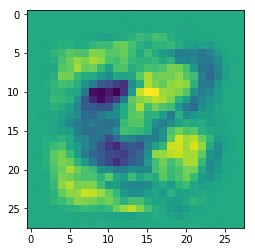

In [41]:
classWeightsToVisualize = 3
plt.imshow(scipy.reshape(w[:,classWeightsToVisualize],[28,28]))

 ...]

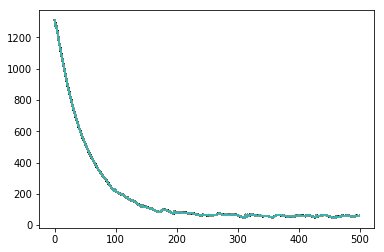

In [10]:
# check if converge
plt.plot(losses)

### Accuracy

In [37]:
def softmax(w, X_train):
    f = X_train.dot(w)
    f -= np.matrix(np.max(f, axis=1)).T
    sm = np.exp(f) / np.sum(np.exp(f), axis=1).reshape(X_train.shape[0], 1)
    return sm

In [38]:
def getProbsAndPreds(w, X_train):
    f = X_train.dot(w)
    f -= np.matrix(np.max(f, axis=1)).T
    probs = np.exp(f) / np.sum(np.exp(f), axis=1).reshape(X_train.shape[0], 1)
    preds = np.argmax(probs, axis=1)
    return probs, preds

In [39]:
def getAccuracy(w, X_train, y_train):
    probs, preds = getProbsAndPreds(w, X_train)
    accuracy = sum(preds == y_train.astype(int))/(float(len(y_train.astype(int))))
    return accuracy

In [40]:
accuracy = getAccuracy(w, X_train, y_train)
print('training accuracy:', accuracy)

training accuracy: 0.8055


### Get Misclassified Images

In [135]:
probs, preds = getProbsAndPreds(w, X_train)

In [146]:
misClassified_index = []
for i in range(len(preds)):
    if preds[i] != y_train.astype(int)[i]:
        misClassified_index.append(i)

In [150]:
len(misClassified_index)

1167

8 0
5 8
9 7
5 4
5 8


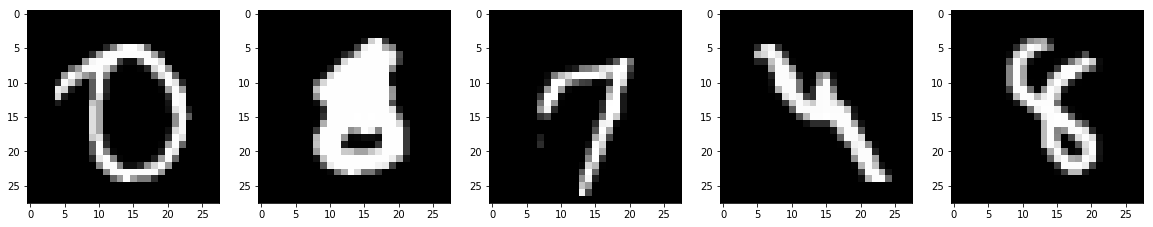

In [152]:
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misClassified_index[0:5]):
    plt.subplot(1, 5, plotIndex + 1)
    plt.imshow(np.reshape(X_train[badIndex], (28,28)), cmap=plt.cm.gray)
    print(preds[badIndex],y_train.astype(int)[badIndex])